# CSC411 Project 3

## Part 1 Preparation of data

In [1]:
import random
import numpy as np
import math

In [2]:
#prepare datasets
#designate 0 = fake, 1 = real for our labels

fake_data = "clean_fake.txt"
real_data = "clean_real.txt"

fake = []
for line in open(fake_data):
    l = line.rstrip('\n').split()
    fake.append(l)
    
real = []
for line in open(real_data):
    l = line.rstrip('\n').split()
    real.append(l)
    
random.seed(1)
random.shuffle(fake)
random.seed(1)
random.shuffle(real)

train_set, valid_set, test_set = [], [], []
train_label, valid_label, test_label = [], [], []

for i in range(len(fake)):
    if i < 0.7*len(fake):
        train_set.append(fake[i])
        train_label.append(0)
    elif i < 0.85*len(fake):
        valid_set.append(fake[i])
        valid_label.append(0)
    else:
        test_set.append(fake[i])
        test_label.append(0)

for i in range(len(real)):
    if i < 0.7*len(real):
        train_set.append(real[i])
        train_label.append(1)
    elif i < 0.85*len(real):
        valid_set.append(real[i])
        valid_label.append(1)
    else:
        test_set.append(real[i])
        test_label.append(1)

In [3]:
#check compositions
sum = len(train_set) + len(valid_set) + len(test_set)
print len(train_set) / float(sum)
print len(valid_set) / float(sum)
print len(test_set) / float(sum)


0.700244947949
0.150030618494
0.149724433558


In [4]:
#construct word frequency dictionary, 
#word_freq = {some_word, (num_label=0, num_label=1)}
word_freq = {}
for i in range(len(train_set)):
    unique_words = set(train_set[i])
    for word in unique_words:
        if word in word_freq:
            if train_label[i] == 0: 
                word_freq[word] = (word_freq[word][0]+1, word_freq[word][1])
            elif train_label[i] == 1: 
                word_freq[word] = (word_freq[word][0], word_freq[word][1]+1)
        else:
            if train_label[i] == 0: 
                word_freq[word] = (1, 0)
            elif train_label[i] == 1: 
                word_freq[word] = (0, 1)


In [5]:
#extract all prob_wi_g_fake, prob_wi_g_real
word_freq_list = word_freq.items()

#define hyperparameters
# m = 4.556423559251676
# p_hat = 0.05764749575838839
m = 0.0
p_hat = 0.0

#count number of fake instances
num_fake = train_label.count(0)
num_real = train_label.count(1)

prob_real = num_real / float(num_fake+num_real)
prob_fake = num_fake / float(num_fake+num_real)

#get prob of w_is given fake or real news
prob_w_g_fake = []
prob_w_g_real = []
words = []
not_prob_w_g_fake = []
not_prob_w_g_real = []
for word, freq in word_freq.iteritems():
    words.append(word)
    prob_w_g_fake.append((freq[0] + m*p_hat) / (num_fake + m))
    prob_w_g_real.append((freq[1] + m*p_hat) / (num_real + m))
    not_prob_w_g_fake.append(1 - ((freq[0] + m*p_hat) / (num_fake + m)))  
    not_prob_w_g_real.append(1 - (freq[1] + m*p_hat) / (num_real + m))


In [6]:
sorted(zip(words, prob_w_g_fake), key = lambda pair: pair[1], reverse=True)[:10]

[('trump', 0.9900990099009901),
 ('to', 0.29812981298129815),
 ('the', 0.2717271727172717),
 ('donald', 0.18041804180418042),
 ('in', 0.1617161716171617),
 ('for', 0.1474147414741474),
 ('of', 0.14631463146314633),
 ('a', 0.1342134213421342),
 ('and', 0.13091309130913092),
 ('on', 0.12431243124312431)]

In [7]:
sorted(zip(words, prob_w_g_real), key = lambda pair: pair[1], reverse=True)[:10]

[('trump', 0.8838896952104499),
 ('donald', 0.41654571843251087),
 ('to', 0.19666182873730043),
 ('on', 0.11538461538461539),
 ('us', 0.11248185776487664),
 ('trumps', 0.11103047895500726),
 ('in', 0.10304789550072568),
 ('for', 0.09216255442670537),
 ('of', 0.09216255442670537),
 ('says', 0.09143686502177069)]

In [8]:
#Count most frequently used words in fake news
sorted(word_freq.iteritems(), key = lambda x: x[1][0], reverse=True)[:10]

[('trump', (900, 1218)),
 ('to', (271, 271)),
 ('the', (247, 104)),
 ('donald', (164, 574)),
 ('in', (147, 142)),
 ('for', (134, 127)),
 ('of', (133, 127)),
 ('a', (122, 72)),
 ('and', (119, 80)),
 ('on', (113, 159))]

In [9]:
#Count most frequently used words in real news
sorted(word_freq.iteritems(), key = lambda x: x[1][1], reverse=True)[:10]

[('trump', (900, 1218)),
 ('donald', (164, 574)),
 ('to', (271, 271)),
 ('on', (113, 159)),
 ('us', (27, 155)),
 ('trumps', (4, 153)),
 ('in', (147, 142)),
 ('for', (134, 127)),
 ('of', (133, 127)),
 ('says', (36, 126))]

In [10]:
#Finding P(word|spam) and P(word|not spam) for 'america', 'obama', 'turnbull'
some_words = ['america', 'obama', 'turnbull']
for word in some_words:
    print word
    word1 = words.index(word)
    print round(prob_w_g_fake[word1],3)
    print round(prob_w_g_real[word1],3)
    print '===='

america
0.047
0.007
====
obama
0.043
0.016
====
turnbull
0.0
0.026
====


## Part 2 Naive Bayes Classifier

In [11]:
def NB_classifier(train_set, train_label, word_freq, sentence, m, p_hat): 
    #count number of fake and real instances to compute prob_real and prob_fake
    num_fake = train_label.count(0)
    num_real = train_label.count(1)
    prob_real = num_real / float(num_real + num_fake)
    prob_fake = num_fake / float(num_real + num_fake)
 
    #get prob of w_is given fake or real news
    prob_w_g_fake = []
    prob_w_g_real = []
    for word, freq in word_freq.iteritems():
        prob_wi_g_fake = (freq[0] + m*p_hat) / (num_fake + m)
        prob_wi_g_real = (freq[1] + m*p_hat) / (num_real + m)
        
        if word in sentence:
            prob_w_g_fake.append(prob_wi_g_fake)
            prob_w_g_real.append(prob_wi_g_real)
        else:
            prob_w_g_fake.append(1.0-prob_wi_g_fake)
            prob_w_g_real.append(1.0-prob_wi_g_real)
    
    prob_fake_g_sentence = np.exp(np.sum(np.log(prob_w_g_fake)))*prob_fake
    prob_real_g_sentence = np.exp(np.sum(np.log(prob_w_g_real)))*prob_real
    
    if prob_fake_g_sentence > prob_real_g_sentence:
        return 0
    else:
        return 1
    
def accuracy(train_set, train_label, word_freq, my_set, my_label, m=3.0, p_hat=0.1):     
    correct = 0 
    for i in range(len(my_set)) :
        prediction = NB_classifier(train_set, train_label, word_freq, my_set[i], m, p_hat)
        if prediction == my_label[i]:
            correct +=1
    
    return float(correct) / float(len(my_set))
    

In [ ]:
#random search for hyperparameters
trials = 40
res = []
random.seed(1)
for t in range(trials):
    m = random.uniform(0.5, 5.0)
    phat = random.uniform(0.05, 0.3)
    acc = accuracy(train_set, train_label, word_freq, valid_set, valid_label, m, phat)
    res.append((m, phat, acc))
print sorted(res, key = lambda x: x[2], reverse = True)[0]

In [13]:
m = 4.260942967639414
p_hat = 0.15819176697626336

#Test classifier on validation set
print(accuracy(train_set, train_label, word_freq, valid_set, valid_label, m , p_hat))

0.840816326531


In [52]:
#Test classifier on test set
print(accuracy(train_set, train_label, word_freq, test_set, test_label, m , p_hat))

0.854805725971


In [14]:
#Test classifier on training set
print(accuracy(train_set, train_label, word_freq, train_set, train_label, m , p_hat))

0.946217752514


## Part 3
Section A

a.) List the 10 words whose presence most strongly predicts that the news is real.

b.) List the 10 words whose absence most strongly predicts that the news is real.

c.) List the 10 words whose presence most strongly predicts that the news is fake.

d.) List the 10 words whose absence most strongly predicts that the news is fake.

In [41]:
#redo part 1 using different m and p
#extract all prob_wi_g_fake, prob_wi_g_real
word_freq_list = word_freq.items()

#define hyperparameters
m = 4.556423559251676
p_hat = 0.05764749575838839

#count number of fake instances
num_fake = train_label.count(0)
num_real = train_label.count(1)

prob_real = num_real / float(num_fake+num_real)
prob_fake = num_fake / float(num_fake+num_real)

#get prob of w_is given fake or real news
prob_w_g_fake = []
prob_w_g_real = []
words = []
not_prob_w_g_fake = []
not_prob_w_g_real = []
for word, freq in word_freq.iteritems():
    words.append(word)
    prob_w_g_fake.append((freq[0] + m*p_hat) / (num_fake + m))
    prob_w_g_real.append((freq[1] + m*p_hat) / (num_real + m))
    not_prob_w_g_fake.append(1 - ((freq[0] + m*p_hat) / (num_fake + m)))  
    not_prob_w_g_real.append(1 - (freq[1] + m*p_hat) / (num_real + m))


In [42]:
prob_fake_g_w = []
prob_real_g_w = []
prob_fake_g_nw = []
prob_real_g_nw = []

for i, word in enumerate(words):
    prob_fake_g_wi = (prob_w_g_fake[i]*prob_fake) / (prob_w_g_fake[i]*prob_fake + prob_w_g_real[i]*prob_real)
    prob_real_g_wi = (prob_w_g_real[i]*prob_real) / (prob_w_g_fake[i]*prob_fake + prob_w_g_real[i]*prob_real)
    prob_fake_g_nwi = (not_prob_w_g_fake[i]*prob_fake) / (not_prob_w_g_fake[i]*prob_fake + not_prob_w_g_real[i]*prob_real)
    prob_real_g_nwi = (not_prob_w_g_real[i]*prob_real) / (not_prob_w_g_fake[i]*prob_fake + not_prob_w_g_real[i]*prob_real)

    
    prob_fake_g_w.append(prob_fake_g_wi)
    prob_real_g_w.append(prob_real_g_wi)
    
    prob_fake_g_nw.append(prob_fake_g_nwi)
    prob_real_g_nw.append(prob_real_g_nwi)
    
    
    #P(word|real)*P(real)/(P(w|real)P(real)+P(w|fake)P(fake))
#         prob_w_g_fake.append((freq[0] + m*p_hat) / (num_fake + m))
#     prob_w_g_real.append((freq[1] + m*p_hat) / (num_real + m))
#     not_prob_w_g_fake.append(1 - ((freq[0] + m*p_hat) / (num_fake + m)))  
#     not_prob_w_g_real.append(1 - (freq[1] + m*p_hat) / (num_real + m))

In [43]:
part_a = sorted(zip(words,prob_real_g_w), key = lambda pair: pair[1], reverse=True)
part_b = sorted(zip(words,prob_real_g_nw), key = lambda pair: pair[1], reverse=True)
part_c = sorted(zip(words,prob_fake_g_w), key = lambda pair: pair[1], reverse=True)
part_d = sorted(zip(words,prob_fake_g_nw), key = lambda pair: pair[1], reverse=True)

In [44]:
print [word for word, num in part_a[0:10]]

['korea', 'travel', 'turnbull', 'australia', 'trade', 'comments', 'tax', 'paris', 'debate', 'malcolm']


In [45]:
print [word for word, num in part_b[0:10]]

['trump', 'the', 'to', 'hillary', 'a', 'is', 'and', 'in', 'for', 'of']


In [46]:
print [word for word, num in part_c[0:10]]

['breaking', 'cnn', 'daily', 'won', '3', 'woman', 'soros', 'm', 'u', 'my']


In [47]:
print [word for word, num in part_d[0:10]]

['donald', 'trumps', 'us', 'says', 'north', 'korea', 'ban', 'travel', 'turnbull', 'wall']


Section B: removing stopwords

In [209]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [210]:
# 10 non-stopwords that most strongly predict that the news is real
processed_part_a = []
for pair in part_a:
    if pair[0] not in ENGLISH_STOP_WORDS:
        processed_part_a.append(pair)
print [word for word, num in processed_part_a[:10]]

['korea', 'travel', 'turnbull', 'australia', 'trade', 'comments', 'tax', 'paris', 'debate', 'malcolm']


In [211]:
# 10 non-stopwords that most strongly predict that the news is fake.
processed_part_c = []
for pair in part_c:
    if pair[0] not in ENGLISH_STOP_WORDS:
        processed_part_c.append(pair)
print [word for word, num in processed_part_c[:10]]

['breaking', 'cnn', 'daily', 'won', '3', 'woman', 'soros', 'm', 'u', 'fox']


Section C: 

Why might it make sense to remove stop words when interpreting the model? Why might it make sense to keep stop words?

Remove them because you cannot infer context from these words.

You might want to keep them if your model's performance is aided by the stop words. For instance, an recurrent neural network might require some level of syntax understanding.


## Part 4
Logistic Regression Spam Classifier

In [172]:
#convert differents sets into vectors

#construct dictionary with each word having a unique label
word_dict = {}
i = 0
all_sets = train_set + valid_set + test_set
for sentence in all_sets:
    for word in sentence:
        if word not in word_dict:
            word_dict[word] = i
            i += 1

#convert each set to np matrices and vectors
def convert_to_mat(my_set, my_label, word_dict):
    num_unique_words = len(word_dict)
    mat_set = np.zeros((len(my_set), num_unique_words))
    vec_label = np.asarray(my_label).reshape((len(my_label),1))
    not_vec_label = 1 - vec_label
    vec_label = np.hstack((not_vec_label,vec_label))
    
    for i in range(len(my_set)):
        for word in my_set[i]:
            mat_set[i][word_dict[word]] = 1
            
    return mat_set, vec_label
        

In [173]:
x_train, y_train = convert_to_mat(train_set, train_label, word_dict)
x_valid, y_valid = convert_to_mat(valid_set, valid_label, word_dict)
x_test, y_test = convert_to_mat(test_set, test_label, word_dict)
print x_train.shape
print y_train.shape
print x_valid.shape
print y_valid.shape
print x_test.shape
print y_test.shape

(2287, 5832)
(2287, 2)
(490, 5832)
(490, 2)
(489, 5832)
(489, 2)


In [174]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [175]:
# Define Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [190]:
def LR_model(x_train, y_train, x_valid, y_valid, word_dict,num_epochs = 700, learning_rate = 0.001 ):
    # Hyper Parameters 
    input_size = len(word_dict)
    num_classes = 2

    model = LogisticRegression(input_size, num_classes)

    x = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
    y = Variable(torch.from_numpy(np.argmax(y_train, 1)), requires_grad=False).type(torch.LongTensor)

    loss_fn = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    
    train_perf_list = []
    valid_perf_list = []
    epoch_list = []

    for epoch in range(num_epochs+1):

        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            #Print epoch
            print 'Epoch: [{}/{}]'.format(epoch, num_epochs)

            training_input = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
            prediction = model(training_input).data.numpy()            
            train_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_train, 1)))
           
            valid_input = Variable(torch.from_numpy(x_valid), requires_grad=False).type(torch.FloatTensor)
            prediction = model(valid_input).data.numpy()
            valid_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_valid, 1))) 
        
            print "Training Set Performance: {}".format(train_performance)
            print "Validation Set Performance: {}".format(valid_performance)
            train_perf_list.append(train_performance)
            valid_perf_list.append(valid_performance)
            epoch_list.append(epoch)
            
    #plot the curves
    plt.plot(epoch_list, train_perf_list, label='Training Set')
    plt.plot(epoch_list, valid_perf_list, label='Validation Set')
    plt.title('Set Performance vs. Number of Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Set Performance')
    plt.legend()
    plt.show()

    return model

Epoch: [0/700]
Training Set Performance: 0.542632269348
Validation Set Performance: 0.489795918367
Epoch: [50/700]
Training Set Performance: 0.954962833406
Validation Set Performance: 0.810204081633
Epoch: [100/700]
Training Set Performance: 0.967205946655
Validation Set Performance: 0.822448979592
Epoch: [150/700]
Training Set Performance: 0.975513773502
Validation Set Performance: 0.822448979592
Epoch: [200/700]
Training Set Performance: 0.981198076082
Validation Set Performance: 0.816326530612
Epoch: [250/700]
Training Set Performance: 0.98382160035
Validation Set Performance: 0.818367346939
Epoch: [300/700]
Training Set Performance: 0.987319632707
Validation Set Performance: 0.822448979592
Epoch: [350/700]
Training Set Performance: 0.987756886751
Validation Set Performance: 0.822448979592
Epoch: [400/700]
Training Set Performance: 0.98950590293
Validation Set Performance: 0.824489795918
Epoch: [450/700]
Training Set Performance: 0.991254919108
Validation Set Performance: 0.81836734

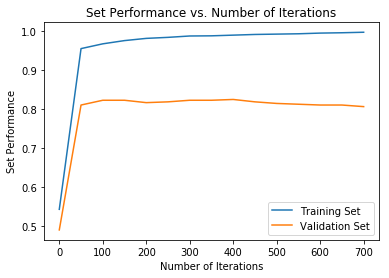

In [193]:
model = LR_model(x_train, y_train, x_valid, y_valid, word_dict, 700, .001)

In [194]:
test_input = Variable(torch.from_numpy(x_test), requires_grad=False).type(torch.FloatTensor)
prediction = model(test_input).data.numpy()
test_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_test, 1)))
print(test_performance)

0.840490797546


In [179]:
def LR_model_L2(x_train, y_train, x_valid, y_valid, word_dict, reg_term=0.01):
    # Hyper Parameters 
    input_size = len(word_dict)
    num_classes = 2
    num_epochs = 700
    learning_rate = 0.001

    model_L2 = LogisticRegression(input_size, num_classes)

    x = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
    y = Variable(torch.from_numpy(np.argmax(y_train, 1)), requires_grad=False).type(torch.LongTensor)

    loss_fn = nn.CrossEntropyLoss()  
    #apply built-in L2 regularization 
    optimizer = torch.optim.Adam(model_L2.parameters(), lr=learning_rate, weight_decay=reg_term) 
    
    train_perf_list = []
    valid_perf_list = []
    epoch_list = []

    for epoch in range(num_epochs+1):

        optimizer.zero_grad()
        outputs = model_L2(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            #Print epoch
            print 'Epoch: [{}/{}]'.format(epoch, num_epochs)

            training_input = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
            prediction = model_L2(training_input).data.numpy()
            train_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_train, 1)))
           
            valid_input = Variable(torch.from_numpy(x_valid), requires_grad=False).type(torch.FloatTensor)
            prediction = model_L2(valid_input).data.numpy()
            valid_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_valid, 1))) 
        
        
            print "Training Set Performance: {}".format(train_performance)
            print "Validation Set Performance: {}".format(valid_performance)
            train_perf_list.append(train_performance)
            valid_perf_list.append(valid_performance)
            epoch_list.append(epoch)
            
    #plot the curves
    plt.plot(epoch_list, train_perf_list, label='Training Set')
    plt.plot(epoch_list, valid_perf_list, label='Validation Set')
    plt.title('Set Performance vs. Number of Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Set Performance')
    plt.legend()
    plt.show()

    return model_L2

Epoch: [0/700]
Training Set Performance: 0.629645824224
Validation Set Performance: 0.602040816327
Epoch: [50/700]
Training Set Performance: 0.920419763883
Validation Set Performance: 0.791836734694
Epoch: [100/700]
Training Set Performance: 0.908176650634
Validation Set Performance: 0.804081632653
Epoch: [150/700]
Training Set Performance: 0.905115872322
Validation Set Performance: 0.810204081633
Epoch: [200/700]
Training Set Performance: 0.899431569742
Validation Set Performance: 0.812244897959
Epoch: [250/700]
Training Set Performance: 0.89637079143
Validation Set Performance: 0.812244897959
Epoch: [300/700]
Training Set Performance: 0.893747267162
Validation Set Performance: 0.814285714286
Epoch: [350/700]
Training Set Performance: 0.889374726716
Validation Set Performance: 0.808163265306
Epoch: [400/700]
Training Set Performance: 0.886751202449
Validation Set Performance: 0.808163265306
Epoch: [450/700]
Training Set Performance: 0.884127678181
Validation Set Performance: 0.8102040

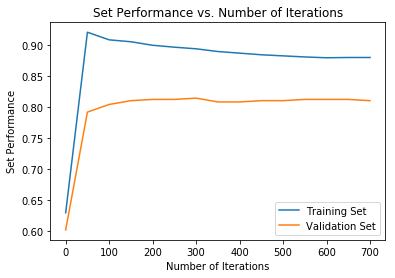

In [180]:
model_L2 = LR_model_L2(x_train, y_train, x_valid, y_valid, word_dict, 0.01)

In [188]:
test_input = Variable(torch.from_numpy(x_test), requires_grad=False).type(torch.FloatTensor)
prediction = model_L2(test_input).data.numpy()
test_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_test, 1)))
print(test_performance)

0.846625766871


In [197]:
def LR_model_L1(x_train, y_train, x_valid, y_valid, word_dict, reg_term):
    # Hyper Parameters 
    input_size = len(word_dict)
    num_classes = 2
    num_epochs = 700
    learning_rate = 0.001
    reg_term = 0.01

    model_L1 = LogisticRegression(input_size, num_classes)

    x = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
    y = Variable(torch.from_numpy(np.argmax(y_train, 1)), requires_grad=False).type(torch.LongTensor)

    loss_fn = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model_L1.parameters(), lr=learning_rate) 
    
    train_perf_list = []
    valid_perf_list = []
    epoch_list = []

    for epoch in range(num_epochs):
        #hacky way of adding L1 regularization
        l1_reg = Variable( torch.FloatTensor(1), requires_grad=True)
        i = 0
        for W in model_L1.parameters():
            if i == 0:
                l1_reg = l1_reg + W.norm(1)
                i += 1
        
        optimizer.zero_grad()
        outputs = model_L1(x)
        loss = loss_fn(outputs, y) + (l1_reg * reg_term)
        loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            #Print epoch
            print 'Epoch: [{}/{}]'.format(epoch, num_epochs)

            training_input = Variable(torch.from_numpy(x_train), requires_grad=False).type(torch.FloatTensor)
            prediction = model_L1(training_input).data.numpy()
            train_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_train, 1)))
           
            valid_input = Variable(torch.from_numpy(x_valid), requires_grad=False).type(torch.FloatTensor)
            prediction = model_L1(valid_input).data.numpy()
            valid_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_valid, 1))) 
        
        
            print "Training Set Performance: {}".format(train_performance)
            print "Validation Set Performance: {}".format(valid_performance)
            train_perf_list.append(train_performance)
            valid_perf_list.append(valid_performance)
            epoch_list.append(epoch)
            
    #plot the curves
    plt.plot(epoch_list, train_perf_list, label='Training Set')
    plt.plot(epoch_list, valid_perf_list, label='Validation Set')
    plt.title('Set Performance vs. Number of Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Set Performance')
    plt.legend()
    plt.show()

    return model_L1

Epoch: [0/700]
Training Set Performance: 0.521206821163
Validation Set Performance: 0.485714285714
Epoch: [50/700]
Training Set Performance: 0.631394840402
Validation Set Performance: 0.636734693878
Epoch: [100/700]
Training Set Performance: 0.643200699606
Validation Set Performance: 0.64693877551
Epoch: [150/700]
Training Set Performance: 0.667686926104
Validation Set Performance: 0.661224489796
Epoch: [200/700]
Training Set Performance: 0.706602536073
Validation Set Performance: 0.708163265306
Epoch: [250/700]
Training Set Performance: 0.708351552252
Validation Set Performance: 0.710204081633
Epoch: [300/700]
Training Set Performance: 0.708351552252
Validation Set Performance: 0.710204081633
Epoch: [350/700]
Training Set Performance: 0.709226060341
Validation Set Performance: 0.710204081633
Epoch: [400/700]
Training Set Performance: 0.708351552252
Validation Set Performance: 0.710204081633
Epoch: [450/700]
Training Set Performance: 0.708788806296
Validation Set Performance: 0.7102040

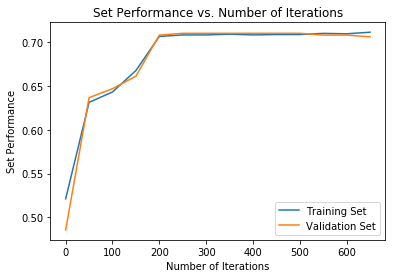

In [198]:
model_L1 = LR_model_L1(x_train, y_train, x_valid, y_valid, word_dict, 1e-5)

In [185]:
test_input = Variable(torch.from_numpy(x_test), requires_grad=False).type(torch.FloatTensor)
prediction = model_L1(test_input).data.numpy()
test_performance = (np.mean(np.argmax(prediction, 1) == np.argmax(y_test, 1)))
print(test_performance)

0.693251533742


## Part 5 
Write in Latex

## Part 6 
Analyzing logistic regression results

In [204]:
#make copy of weights
w = np.copy(model_L2.linear.weight.data.numpy()) 
b = np.copy(model_L2.linear.bias.data.numpy())

#invert word dictionary, so we can map index to word
inv_word_dict = {v: k for k, v in word_dict.iteritems()}

#sort w and return indices
indices_a = np.argsort(w, axis = 1)[:,-10:]

for row in range(2):
    temp = []
    for col in range(indices_a.shape[1]):
        temp.append(inv_word_dict[indices[row,col]])
    print temp


['breaking', 'you', 'watch', 'victory', 'are', 'that', 'is', 'america', 'just', 'the']
['tax', 'comey', 'australia', 'ban', 'turnbull', 'north', 'korea', 'says', 'donald', 'us']


In [215]:
#grab the top 30
indices_b = np.argsort(w, axis = 1)[:,-30:]
fake_words = [inv_word_dict[indices_b[0, col]] for col in range(indices_b.shape[1]) ]
real_words = [inv_word_dict[indices_b[1, col]] for col in range(indices_b.shape[1]) ]

#remove stop words
for word in fake_words:
    if word in ENGLISH_STOP_WORDS:
        fake_words.remove(word)
        
for word in real_words:
    if word in ENGLISH_STOP_WORDS:
        real_words.remove(word)

print fake_words[-10:]
print real_words[-10:]

['win', 'new', 'star', 'breaking', 'watch', 'victory', 'that', 'america', 'just', 'hillary']
['tax', 'comey', 'australia', 'ban', 'turnbull', 'north', 'korea', 'says', 'donald', 'trumps']


## Part 7a

### Preparing the Datasets

In [1]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import matplotlib.pyplot as plt
import random
import numpy as np
import math

#prepare datasets
#designate 0 = fake, 1 = real for our labels

fake_data = "clean_fake.txt"
real_data = "clean_real.txt"

fake = []
for line in open(fake_data):
    l = line.rstrip('\n').split()
    fake.append(l)
    
real = []
for line in open(real_data):
    l = line.rstrip('\n').split()
    real.append(l)
    
random.seed(1)
random.shuffle(fake)
random.seed(1)
random.shuffle(real)

train_set, valid_set, test_set = [], [], []
train_label, valid_label, test_label = [], [], []


for i in range(len(fake)):
    if i < 0.7*len(fake):
        train_set.append(fake[i])
        train_label.append(0)
    elif i < 0.85*len(fake):
        valid_set.append(fake[i])
        valid_label.append(0)
    else:
        test_set.append(fake[i])
        test_label.append(0)

for i in range(len(real)):
    if i < 0.7*len(real):
        train_set.append(real[i])
        train_label.append(1)
    elif i < 0.85*len(real):
        valid_set.append(real[i])
        valid_label.append(1)
    else:
        test_set.append(real[i])
        test_label.append(1)

In [2]:
def process_features(train_set):
    i=0
    features_words={}
    words_features=[]
    for title in train_set:
        for word in title:
            if word not in features_words.keys():
                features_words[word]=i
                words_features.append(word)
                i=i+1
    return features_words,words_features
classifer = DecisionTreeClassifier(max_features=4000,random_state=0)

def create_tree_set(word_set,features_words):
    i=0
    num_of_words=len(features_words.keys())
    tree_set=[]
    for title in word_set:
        tree_set.append(np.zeros(num_of_words))
        for word in title:
            if word in features_words.keys():
                tree_set[i][features_words[word]]+=1
                '''
                if tree_set[i][features_words[word]]>1:
                    print (title)
                '''
        i=i+1
    return tree_set

In [3]:
#Processing the sets---------------
#Getting the words
features_words,words_features=process_features(train_set) #So the features is based solely on the training set

#Creating the new training set
x_trs=create_tree_set(train_set,features_words)
y_trs=train_label

#Creating new validation set
x_vs=create_tree_set(valid_set,features_words)
y_vs=valid_label

#Creating new test set
x_tes=create_tree_set(test_set,features_words)
y_tes=test_label

### Exploring max_depth

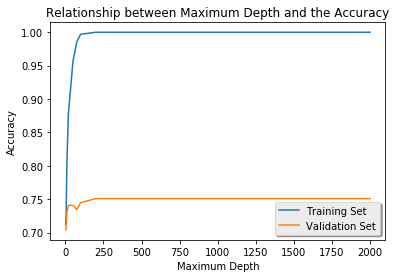

In [4]:
trs_data=[]
vs_data=[]
#tes_data=[]
max_depth_record=[]
depths_to_try=[2,5,10,20,50,75,100,200,250,500,1000,2000]
for num_depth in depths_to_try:
    classifier = DecisionTreeClassifier(max_depth=num_depth, random_state=0)
    classifier.fit(x_trs, y_trs)
    
    trs_data.append(classifier.score(x_trs, y_trs))
    vs_data.append(classifier.score(x_vs, y_vs))
    #tes_data.append(classifier.score(x_tes, y_tes))
    max_depth_record.append(num_depth)

plt.plot(max_depth_record,trs_data,label="Training Set")
plt.plot(max_depth_record,vs_data,label='Validation Set')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Relationship between Maximum Depth and the Accuracy')
plt.legend(loc='lower right', shadow=True)
plt.show()

### Creating the final decision tree based on findings

In [5]:
#We found that max_features has an effect on the performance. The explorations can be found in Aside 7.1 and 7.2
classifier = DecisionTreeClassifier(max_features=250, random_state=0)
classifier.fit(x_trs, y_trs)
print ("Performance on Training Set:",classifier.score(x_trs, y_trs))
print ("Performance on Validation Set:",classifier.score(x_vs, y_vs))
print ("Performance on Test Set:",classifier.score(x_tes, y_tes))

Performance on Training Set: 1.0
Performance on Validation Set: 0.769387755102
Performance on Test Set: 0.791411042945


### Aside 7.1: How the leaves are classfied (DON'T NEED TO RUN)

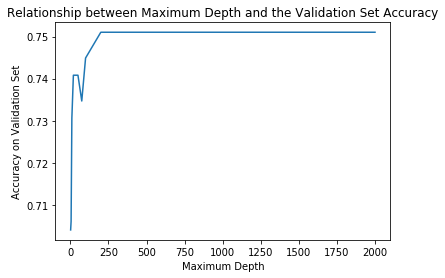

In [6]:
#DON'T NEED TO RUN, but is runnable
'''
We also explored how the leaves are classified
The following code is essentially the same as the code for exploring max_depth. 
Here, instead of using classifier.score(), we manually classified the leaves and then tested it
'''
performance_record=[]
max_depth_record=[]
depths_to_try=[2,5,10,20,50,75,100,200,250,500,1000,2000]
for num_depth in depths_to_try:
    c = DecisionTreeClassifier(max_depth=num_depth, random_state=0)
    c.fit(x_trs, y_trs)

    #Using training set to classify the leaves
    y_trs_pred=c.apply(x_trs) #Contains the leaf ids of the results of each test case
    i=0
    leaves={}
    for leafID in y_trs_pred:
        if leafID not in leaves.keys():
            leaves[leafID]=0

        if y_trs[i]==0: #Fake
            leaves[leafID]-=1
        else:#Real
            leaves[leafID]+=1
        i+=1

    for leafID in leaves.keys():
        if leaves[leafID]<0:#Fake
            leaves[leafID]=0
        elif leaves[leafID]>0:#Real
            leaves[leafID]=1
        else:
            #print ("# Fake=#Real for node",leafID)
            leaves[leafID]=1 #OR USE RANDOMIZER

    #Using validation set to test the accuracy of the decision tree
    y_vs_pred=c.apply(x_vs)
    correct=0 
    i=0
    for leafID in y_vs_pred:
        if leaves[leafID]==y_vs[i]:
            correct+=1
        i+=1
    #print ("Performance:",correct/len(y_vs))
    #print (num_leaf_nodes)
    performance_record.append(correct/len(y_vs))
    max_depth_record.append(num_depth)

plt.plot(max_depth_record, performance_record)
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy on Validation Set')
plt.title('Relationship between Maximum Depth and the Validation Set Accuracy')
plt.show()

#The resulting graph matches the one using the classifier.score() function

### Aside 7.2: Exploring max_features (DON'T NEED TO RUN)

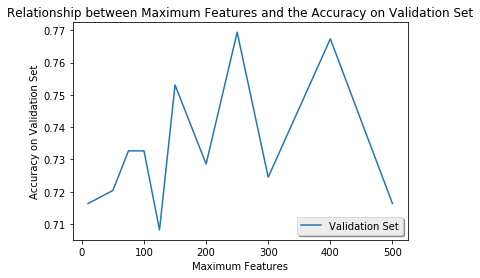

In [7]:
#DON'T NEED TO RUN, but is runnable

trs_data=[]
vs_data=[]
max_depth_record=[]
nums_to_try=[10,50,75,100,125,150,200,250,300,400,500]

for num_features in nums_to_try:
    c = DecisionTreeClassifier(max_features=num_features, max_depth=250,random_state=0)
    c.fit(x_trs, y_trs)
    
    trs_data.append(c.score(x_trs, y_trs))
    vs_data.append(c.score(x_vs, y_vs))
    #tes_data.append(c.score(x_tes, y_tes))
    max_depth_record.append(num_features)


#plt.plot(max_depth_record,trs_data,label="Training Set")
plt.plot(max_depth_record,vs_data,label='Validation Set')
plt.xlabel('Maximum Features')
plt.ylabel('Accuracy on Validation Set')
plt.title('Relationship between Maximum Features and the Accuracy on Validation Set')
plt.legend(loc='lower right', shadow=True)
plt.show()

### Aside 7.3: Exploring max_leaf_nodes (DON'T NEED TO RUN)

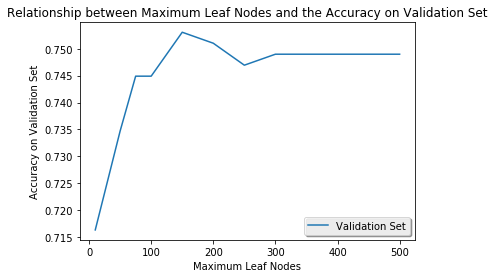

In [8]:
#DON'T NEED TO RUN, but is runnable

trs_data=[]
vs_data=[]
max_depth_record=[]
nums_to_try=[10,50,75,100,125,150,200,250,300,400,500]

for max_leaves in nums_to_try:
    c = DecisionTreeClassifier(max_leaf_nodes=max_leaves, max_depth=250,random_state=0)
    c.fit(x_trs, y_trs)
    
    trs_data.append(c.score(x_trs, y_trs))
    vs_data.append(c.score(x_vs, y_vs))
    #tes_data.append(c.score(x_tes, y_tes))
    max_depth_record.append(max_leaves)


#plt.plot(max_depth_record,trs_data,label="Training Set")
plt.plot(max_depth_record,vs_data,label='Validation Set')
plt.xlabel('Maximum Leaf Nodes')
plt.ylabel('Accuracy on Validation Set')
plt.title('Relationship between Maximum Leaf Nodes and the Accuracy on Validation Set')
plt.legend(loc='lower right', shadow=True)
plt.show()

## Part 7b

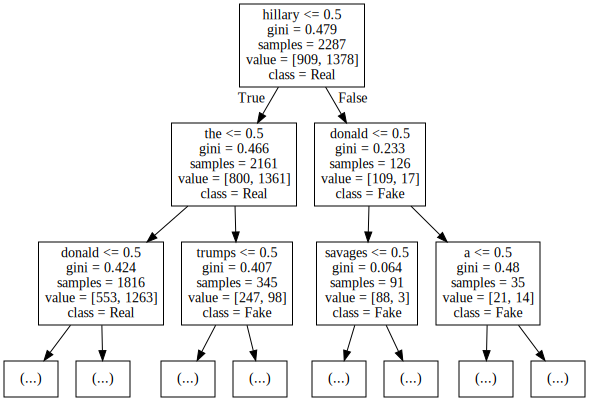

In [9]:
import graphviz 
classifer.fit(x_trs, y_trs)
#export_graphviz(classifer, out_file='tree.dot',feature_names=words_features,class_names=["Fake","Real"],max_depth=2)
dot_data = export_graphviz(classifer, out_file=None,feature_names=words_features,class_names=["Fake","Real"],max_depth=2)
graph = graphviz.Source(dot_data)  
graph

## Part 8

In [10]:
#I(Y,xi)=H(Y)-H(Y|xi) where Y is 0 or 1 (real or fake) and xi is the keyword for first split
#H(Y)=P(real)log2P(real)+P(fake)log2P(fake)
#H(Y|xi)=P(have xi)[-P(real|havexi)log2P(real|havexi)-P(fake|havexi)log2P(fake|havexi)] + P(doesn't havexi)[etc.]
def entropy(V):
    sum=0
    for v in V:
        sum-=v*math.log(v,2)
    return sum

def mutual_info(xi):
    num_total=len(x_trs)
    num_real=np.count_nonzero(y_trs)
    num_fake=num_total-num_real
    num_havexi=np.count_nonzero(np.array(x_trs)[:,features_words[xi]])
    num_not_havexi=num_total-num_havexi
    num_real_havexi=np.count_nonzero(np.array(x_trs)[:,features_words[xi]]*np.array(y_trs))
    num_fake_havexi=num_havexi-num_real_havexi
    num_real_not_havexi=num_real-num_real_havexi
    num_fake_not_havexi=num_not_havexi-num_real_not_havexi
    HY=entropy([num_real/num_total,num_fake/num_total])
    HYxi=(num_havexi/num_total)*entropy([num_real_havexi/num_havexi,num_fake_havexi/num_havexi])
    HYxi+=(num_not_havexi/num_total)*entropy([num_real_not_havexi/num_not_havexi,num_fake_not_havexi/num_not_havexi])
    IYxi=HY-HYxi
    
    return IYxi

In [14]:
word_top_most_split=words_features[classifer.tree_.feature[0]]
print ("Top most keyword (",word_top_most_split,"):", mutual_info(word_top_most_split))
print ("Another keyword ( election ):", mutual_info('election'))

Top most keyword ( hillary ): 0.03956116386393127
Another keyword ( election ): 0.00113715241004686
